In [11]:
import sys
!{sys.executable} -m pip install catboost --prefer-binary

  Using cached graphviz-0.20.1-py3-none-any.whl.metadata (12 kB)
   --------------------------------------- 101.7/101.7 MB 24.2 MB/s eta 0:00:00
Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)


# 모델링

### 재반등 횟수와 관련된 컬럼들은 하나씩 사용

In [13]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# 데이터 로드
df = pd.read_csv("final_data_rebounds.csv")

# 타겟: 상영일수
target = '상영일수'
rebound_columns = ['재반등횟수', '3일뒤_재반등횟수', '7일뒤_재반등횟수', '10일뒤_재반등횟수']

# 결측 제거 (타겟과 재반등 컬럼)
df = df.dropna(subset=[target] + rebound_columns)

# 범주형 컬럼 식별
cat_features = df.select_dtypes(include='object').columns.tolist()

# ✅ 범주형 컬럼 NaN을 'missing'으로 처리
df[cat_features] = df[cat_features].fillna('missing')

# 결과 저장
results = []
trained_models = {}
feature_sets = {}

for rebound in rebound_columns:
    # 나머지 재반등 컬럼은 피처에서 제외
    excluded = [col for col in rebound_columns if col != rebound]
    feature_cols = [col for col in df.columns if col != target and col not in excluded]

    X = df[feature_cols]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = CatBoostRegressor(verbose=0, random_seed=42)
    model.fit(X_train, y_train, cat_features=cat_features)

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        '사용한 재반등 피처': rebound,
        'MAE': round(mae, 3),
        'R²': round(r2, 3)
    })

    trained_models[rebound] = model
    feature_sets[rebound] = X.columns

# 결과 출력
results_df = pd.DataFrame(results)
print("🔍 예측 성능 비교:")
print(results_df)


🔍 예측 성능 비교:
   사용한 재반등 피처    MAE     R²
0       재반등횟수  1.332  0.971
1   3일뒤_재반등횟수  1.070  0.981
2   7일뒤_재반등횟수  1.043  0.982
3  10일뒤_재반등횟수  1.158  0.970


# 피쳐 중요도 


📊 Feature Importance for: 재반등횟수


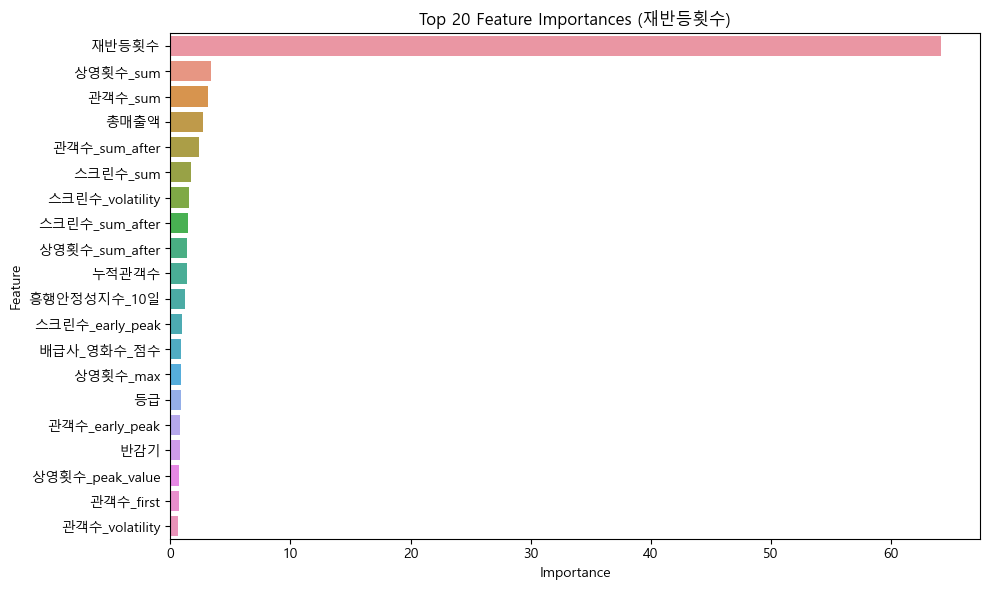


📊 Feature Importance for: 3일뒤_재반등횟수


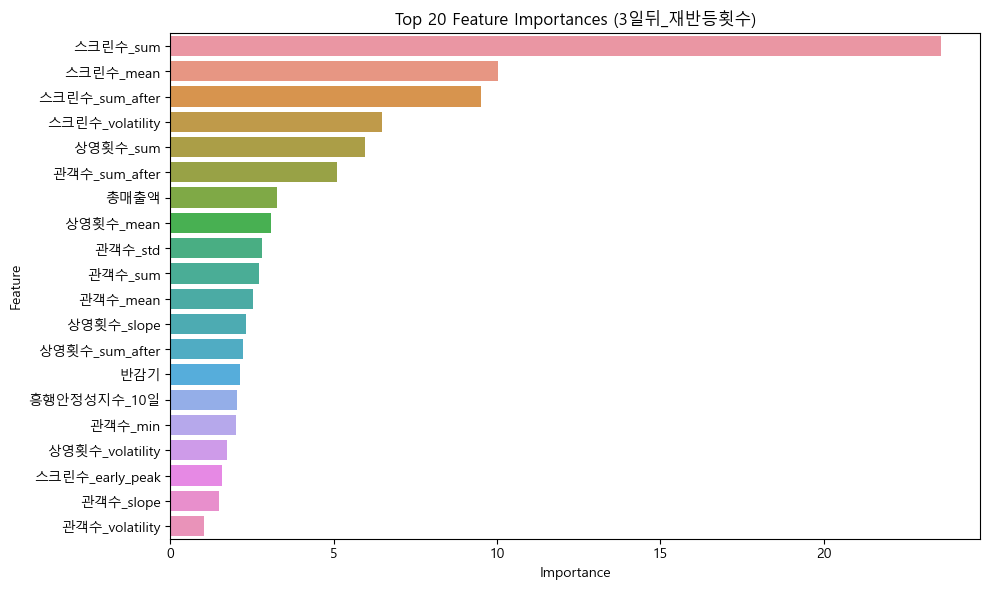


📊 Feature Importance for: 7일뒤_재반등횟수


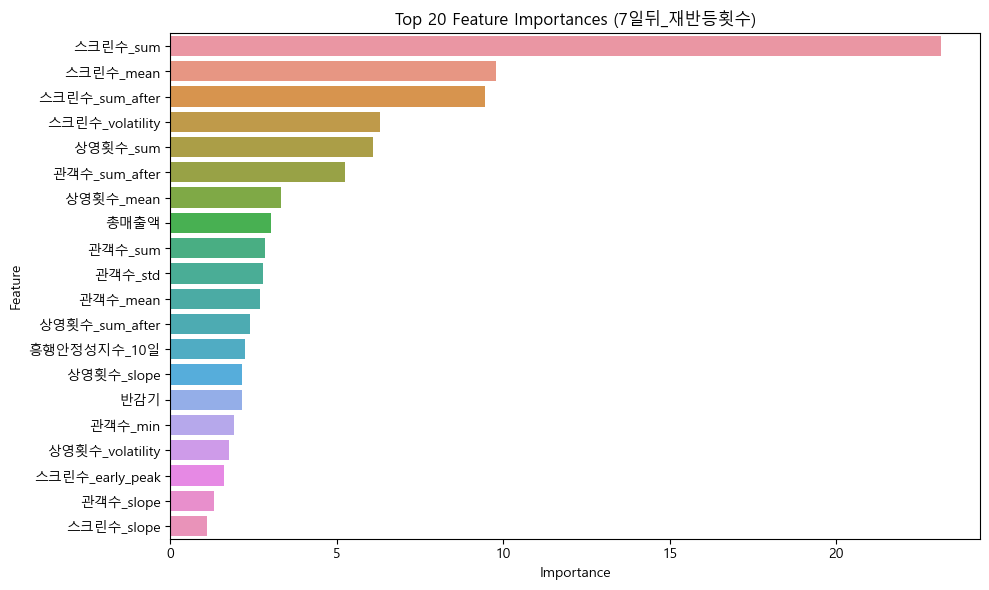


📊 Feature Importance for: 10일뒤_재반등횟수


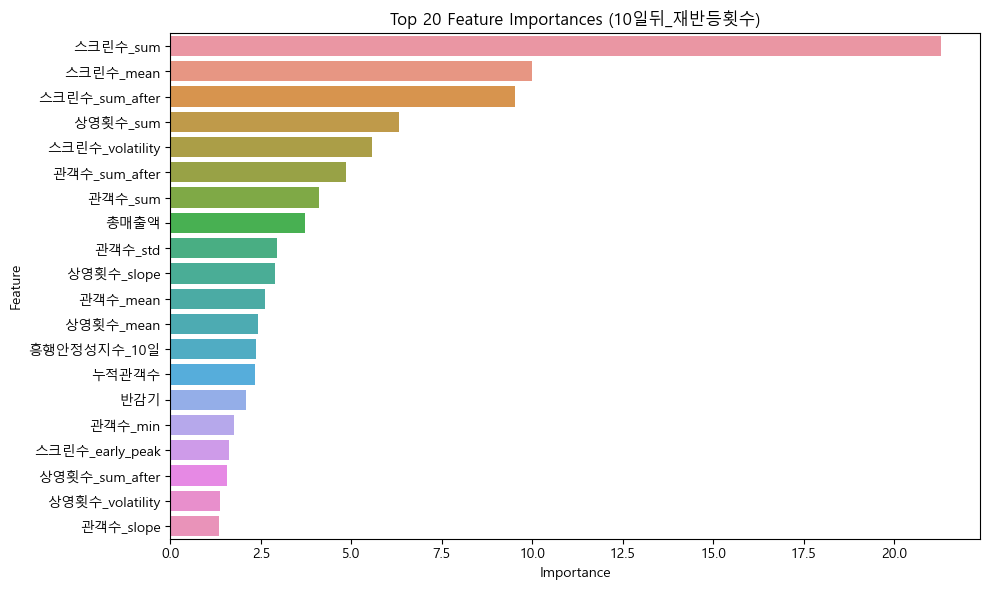

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

def plot_feature_importance(model, feature_names, top_n=20, title_suffix=""):
    importances = model.get_feature_importance()
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Top {top_n} Feature Importances ({title_suffix})')
    plt.tight_layout()
    plt.show()

# 모든 모델에 대해 피처 중요도 출력
for rebound in rebound_columns:
    print(f"\n📊 Feature Importance for: {rebound}")
    plot_feature_importance(trained_models[rebound], feature_sets[rebound], top_n=20, title_suffix=rebound)


# 모델링 (압축)

In [1]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# 데이터 로드
df = pd.read_csv("final_data_rebounds.csv")

# 타겟 및 재반등 피처
target = '상영일수'
rebound_columns = ['재반등횟수', '3일뒤_재반등횟수', '7일뒤_재반등횟수', '10일뒤_재반등횟수']

# 장르/국적 원-핫 컬럼
genre_columns = [col for col in df.columns if col.startswith('장르_') and '점수' not in col]
nation_columns = [col for col in df.columns if col.startswith('국적_') and '점수' not in col]

# 원-핫 인코딩 압축 함수
def compress_one_hot(row, columns, prefix):
    active = row[columns]
    if active.isnull().all():
        return 'missing'
    max_val = active.max()
    if pd.isna(max_val):
        return 'missing'
    # 최대값을 가지는 모든 컬럼의 접두사 제거 후 join
    max_cols = active[active == max_val].index
    categories = [col.replace(f"{prefix}_", "") for col in max_cols]
    return ",".join(categories) if categories else 'missing'

# 압축 컬럼 생성
df['장르_압축'] = df.apply(lambda row: compress_one_hot(row, genre_columns, '장르'), axis=1)
df['국적_압축'] = df.apply(lambda row: compress_one_hot(row, nation_columns, '국적'), axis=1)

# 모델 입력용 데이터프레임
df_model = df.drop(columns=genre_columns + nation_columns)
df_model = df_model.dropna(subset=[target] + rebound_columns)

# 범주형 처리
cat_features = df_model.select_dtypes(include='object').columns.tolist()
df_model[cat_features] = df_model[cat_features].fillna('missing')

# 결과 저장
results = []
trained_models = {}
feature_sets = {}

for rebound in rebound_columns:
    excluded = [col for col in rebound_columns if col != rebound]
    feature_cols = [col for col in df_model.columns if col != target and col not in excluded]

    X = df_model[feature_cols]
    y = df_model[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = CatBoostRegressor(verbose=0, random_seed=42)
    model.fit(X_train, y_train, cat_features=cat_features)

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        '사용한 재반등 피처': rebound,
        'MAE': round(mae, 3),
        'R²': round(r2, 3)
    })

    # 🔹 모델 및 피처 저장
    trained_models[rebound] = model
    feature_sets[rebound] = X.columns
    
results_df = pd.DataFrame(results)
print(results_df)


   사용한 재반등 피처    MAE     R²
0       재반등횟수  1.246  0.976
1   3일뒤_재반등횟수  1.125  0.978
2   7일뒤_재반등횟수  1.157  0.977
3  10일뒤_재반등횟수  1.178  0.974



📊 Feature Importance for: 재반등횟수


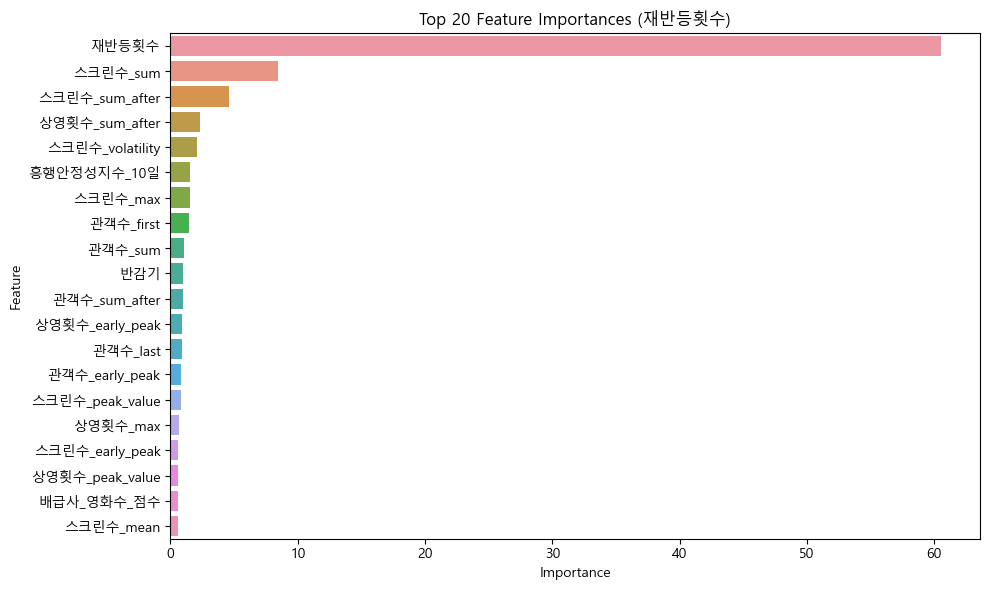


📊 Feature Importance for: 3일뒤_재반등횟수


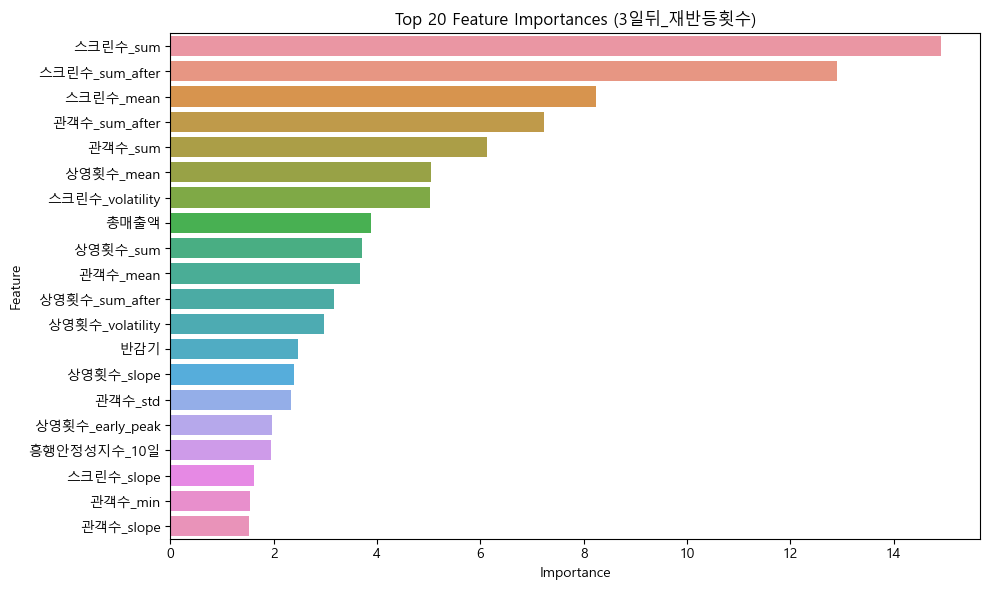


📊 Feature Importance for: 7일뒤_재반등횟수


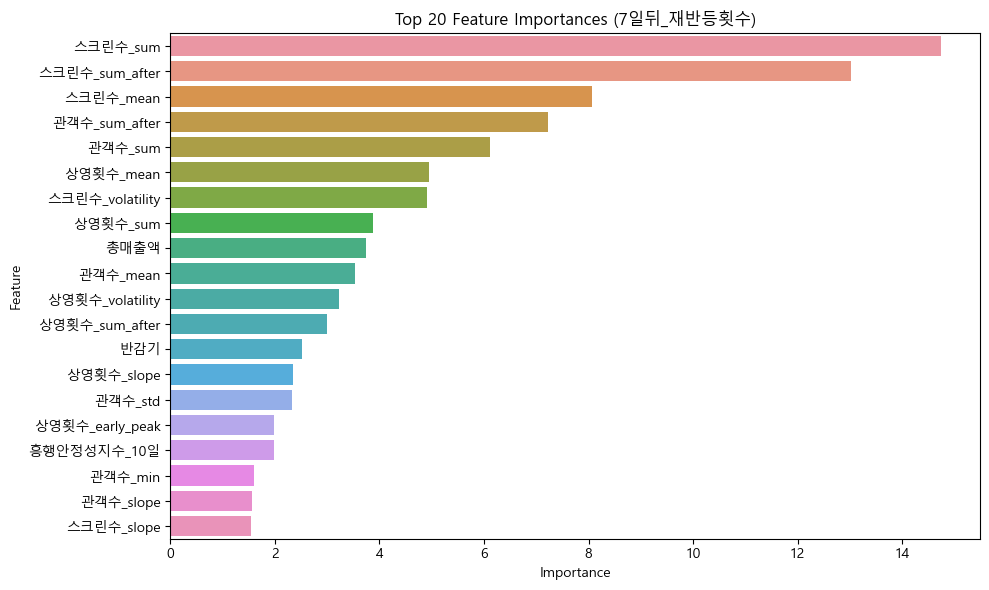


📊 Feature Importance for: 10일뒤_재반등횟수


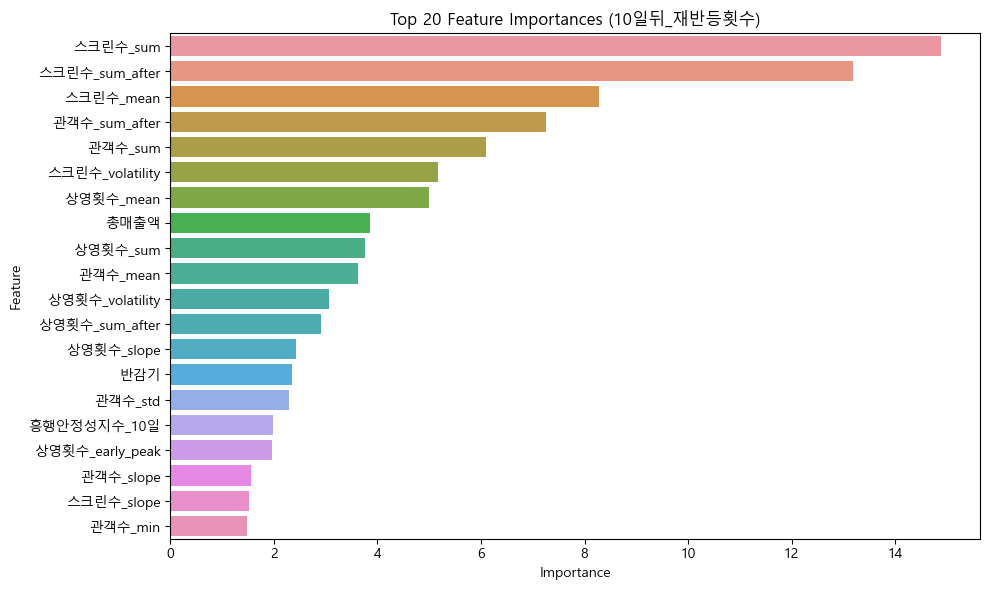

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

def plot_feature_importance(model, feature_names, top_n=20, title_suffix=""):
    importances = model.get_feature_importance()
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Top {top_n} Feature Importances ({title_suffix})')
    plt.tight_layout()
    plt.show()

# 📊 모든 모델에 대해 시각화 반복
for rebound in rebound_columns:
    print(f"\n📊 Feature Importance for: {rebound}")
    plot_feature_importance(trained_models[rebound], feature_sets[rebound], top_n=20, title_suffix=rebound)


# 7일뒤_재반등횟수 + 비압축

In [24]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# 데이터 로드
df = pd.read_csv("final_data_rebounds.csv")

# 타겟 및 선택할 피처
target = '상영일수'
rebound = '7일뒤_재반등횟수'
rebound_columns = ['재반등횟수', '3일뒤_재반등횟수', '7일뒤_재반등횟수', '10일뒤_재반등횟수']

# 결측값 제거
df = df.dropna(subset=[target] + rebound_columns)

# 범주형 컬럼 식별 및 NaN 처리
cat_features = df.select_dtypes(include='object').columns.tolist()
df[cat_features] = df[cat_features].fillna('missing')

# 피처 설정: 나머지 재반등 컬럼은 제거
excluded = [col for col in rebound_columns if col != rebound]
feature_cols = [col for col in df.columns if col != target and col not in excluded]

X = df[feature_cols]
y = df[target]

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 훈련
model = CatBoostRegressor(verbose=0, random_seed=42)
model.fit(X_train, y_train, cat_features=cat_features)

# 예측 및 평가
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📌 '7일뒤_재반등횟수 + 비압축' 모델 성능:")
print(f"MAE: {mae:.3f}")
print(f"R² : {r2:.3f}")


📌 '7일뒤_재반등횟수 + 비압축' 모델 성능:
MAE: 1.043
R² : 0.982


# XAI

### SHAP, PDP/ICE

### SHAP

In [31]:
import sys
!{sys.executable} -m pip install shap

   --------------------------------------- 462.1/462.1 kB 14.6 MB/s eta 0:00:00
   ---------------------------------------- 2.5/2.5 MB 39.7 MB/s eta 0:00:00
   ---------------------------------------- 23.2/23.2 MB 34.4 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


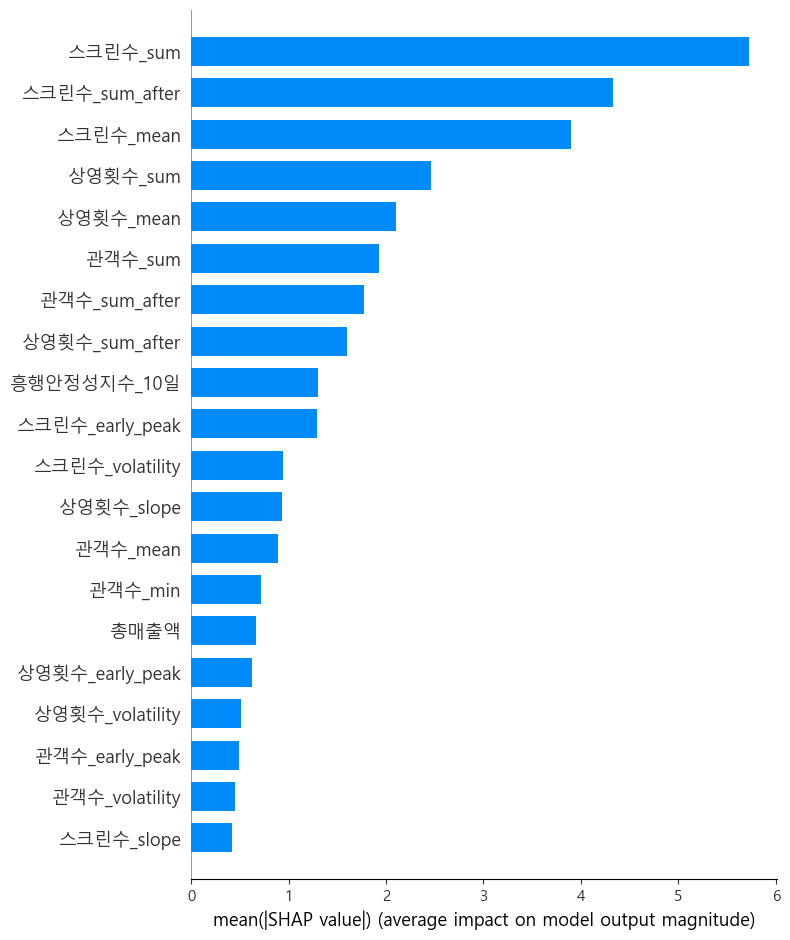

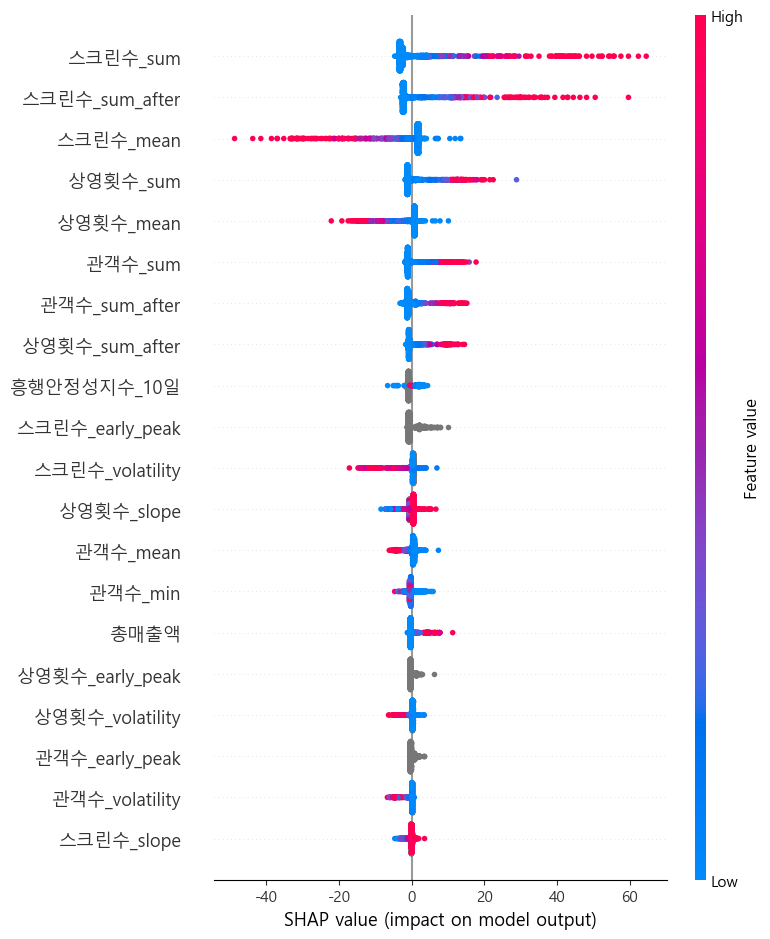

In [33]:
import shap

# SHAP Explainer 생성
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 전체 feature 중요도 요약 플롯
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 상세한 분포 시각화 (예: 7일뒤_재반등횟수)
shap.summary_plot(shap_values, X_test)


값이 양수: 모델이 예측한 상영일수 증가에 기여 <br>
값이 음수: 모델이 예측한 상영일수 감소에 기여

값이 0에 가까움: 모델에 미치는 영향이 작음 

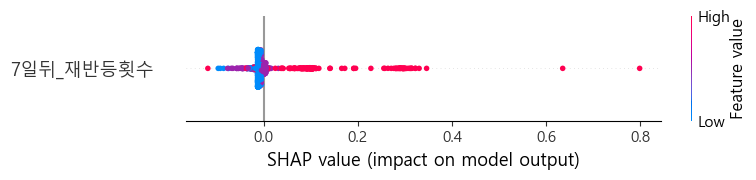

In [48]:
import shap

# SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 대상 피처 선택
feature_name = '7일뒤_재반등횟수'
X_subset = X_test[[feature_name]]  # ✅ DataFrame 형태 유지
shap_subset = shap_values[:, X_test.columns.get_loc(feature_name)].reshape(-1, 1)

# summary plot
shap.summary_plot(
    shap_subset,
    features=X_subset,
    feature_names=[feature_name]
)


### LIME

### PDP/ICE

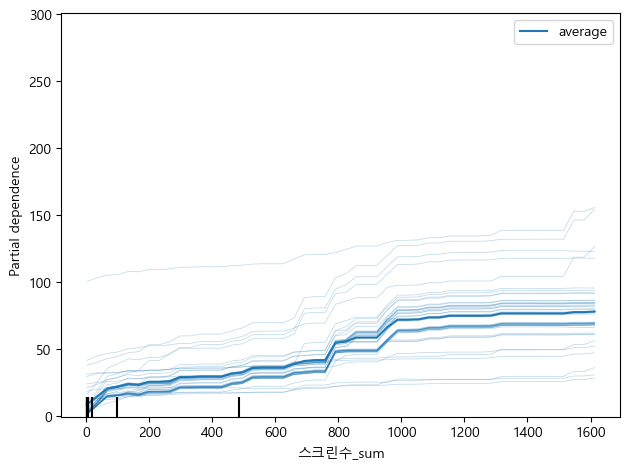

In [45]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 시각화할 피처 지정
features_to_plot = [('스크린수_sum')]  # 또는 다른 중요 피처 이름

# PartialDependenceDisplay 생성
display = PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=X_test,
    features=features_to_plot,
    kind='both',  # 'average' = PDP, 'individual' = ICE, 'both' = PDP+ICE
    subsample=50,  # ICE 그릴 때 사용할 샘플 수 (너무 많으면 느려짐)
    grid_resolution=50,  # x축 점 개수
    random_state=42
)

# 시각화 출력
plt.tight_layout()
plt.show()

800 ~ 1000 구간이 모델이 중요하게 여기는 임계점일 수 있음 